# Bike-Sharing Dataset

The [Bike-Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset) This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information. The dataset contains 14 features with information about the day-type, e.g., month, hour, which day of the week, whether it is working-day, and the weather conditions, e.g., temperature, humidity, wind speed, etc. The target variable is the number of bike rentals per hour. The dataset contains 17,379 instances. 

In [1]:
import effector
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)


2024-01-08 12:32:29.285375: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-08 12:32:29.317781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 12:32:29.317803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 12:32:29.318628: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 12:32:29.323579: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-08 12:32:29.323792: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Preprocess the data

In [2]:
# load dataset
df = pd.read_csv("./../data/Bike-Sharing-Dataset/hour.csv")

# drop columns
df = df.drop(["instant", "dteday", "casual", "registered", "atemp"], axis=1)

In [3]:
for col_name in df.columns:
    print("Feature: {:15}, unique: {:4d}, Mean: {:6.2f}, Std: {:6.2f}, Min: {:6.2f}, Max: {:6.2f}".format(col_name, len(df[col_name].unique()), df[col_name].mean(), df[col_name].std(), df[col_name].min(), df[col_name].max()))

Feature: season         , unique:    4, Mean:   2.50, Std:   1.11, Min:   1.00, Max:   4.00
Feature: yr             , unique:    2, Mean:   0.50, Std:   0.50, Min:   0.00, Max:   1.00
Feature: mnth           , unique:   12, Mean:   6.54, Std:   3.44, Min:   1.00, Max:  12.00
Feature: hr             , unique:   24, Mean:  11.55, Std:   6.91, Min:   0.00, Max:  23.00
Feature: holiday        , unique:    2, Mean:   0.03, Std:   0.17, Min:   0.00, Max:   1.00
Feature: weekday        , unique:    7, Mean:   3.00, Std:   2.01, Min:   0.00, Max:   6.00
Feature: workingday     , unique:    2, Mean:   0.68, Std:   0.47, Min:   0.00, Max:   1.00
Feature: weathersit     , unique:    4, Mean:   1.43, Std:   0.64, Min:   1.00, Max:   4.00
Feature: temp           , unique:   50, Mean:   0.50, Std:   0.19, Min:   0.02, Max:   1.00
Feature: hum            , unique:   89, Mean:   0.63, Std:   0.19, Min:   0.00, Max:   1.00
Feature: windspeed      , unique:   30, Mean:   0.19, Std:   0.12, Min:   0.00, 

Feature analysis:

| Feature      | Description                              | Value Range                                           |
|--------------|------------------------------------------|-------------------------------------------------------|
| season       | season                                   | 1: winter, 2: spring, 3: summer, 4: fall              |
| yr           | year                                     | 0: 2011, 1: 2012                                      |
| mnth         | month                                    | 1 to 12                                               |
| hr           | hour                                     | 0 to 23                                               |
| holiday      | whether the day is a holiday or not      | 0: no, 1: yes                                         |
| weekday      | day of the week                          | 0: Sunday, 1: Monday, …, 6: Saturday                  |
| workingday   | whether the day is a working day or not  | 0: no, 1: yes                                         |
| weathersit   | weather situation                        | 1: clear, 2: mist, 3: light rain, 4: heavy rain       |
| temp         | temperature                              | values in [0.02, 1.00], with mean: 0.50 and std: 0.19 |
| hum          | humidity                                 | values in [0.00, 1.00], with mean: 0.63 and std: 0.19 |
| windspeed    | wind speed                               | values in [0.00, 0.85], with mean: 0.19 and std: 0.12 |


Target variable:

| Target       | Description                            | Value Range                                          |
|--------------|----------------------------------------|------------------------------------------------------|
| cnt          | bike rentals per hour                  | values in [1, 977] with mean: 189.46 and std: 181.39 |


In [4]:
def preprocess(df):
    # Standarize X
    X_df = df.drop(["cnt"], axis=1)
    x_mean = X_df.mean()
    x_std = X_df.std()
    X_df = (X_df - X_df.mean()) / X_df.std()

    # Standarize Y
    Y_df = df["cnt"]
    y_mean = Y_df.mean()
    y_std = Y_df.std()
    Y_df = (Y_df - Y_df.mean()) / Y_df.std()
    return X_df, Y_df, x_mean, x_std, y_mean, y_std

# shuffle and standarize all features
X_df, Y_df, x_mean, x_std, y_mean, y_std = preprocess(df)

In [5]:
def split(X_df, Y_df):
    # shuffle indices
    indices = X_df.index.tolist()
    np.random.shuffle(indices)
    
    # data split
    train_size = int(0.8 * len(X_df))
    
    X_train = X_df.iloc[indices[:train_size]]
    Y_train = Y_df.iloc[indices[:train_size]]
    X_test = X_df.iloc[indices[train_size:]]
    Y_test = Y_df.iloc[indices[train_size:]]
    
    return X_train, Y_train, X_test, Y_test

# train/test split
X_train, Y_train, X_test, Y_test = split(X_df, Y_df)


## Fit a Neural Network

In [6]:
# Train - Evaluate - Explain a neural network
model = keras.Sequential([
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae", keras.metrics.RootMeanSquaredError()])
model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1)
model.evaluate(X_train, Y_train, verbose=1)
model.evaluate(X_test, Y_test, verbose=1)


Epoch 1/20


2024-01-08 12:32:30.734942: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


28/28 [==============================] - 1s 10ms/step - loss: 0.5033 - mae: 0.5128 - root_mean_squared_error: 0.7094
Epoch 2/20
28/28 [==============================] - 0s 10ms/step - loss: 0.3610 - mae: 0.4337 - root_mean_squared_error: 0.6009
Epoch 3/20
28/28 [==============================] - 0s 10ms/step - loss: 0.2752 - mae: 0.3688 - root_mean_squared_error: 0.5246
Epoch 4/20
28/28 [==============================] - 0s 10ms/step - loss: 0.2063 - mae: 0.3180 - root_mean_squared_error: 0.4542
Epoch 5/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1567 - mae: 0.2754 - root_mean_squared_error: 0.3958
Epoch 6/20
28/28 [==============================] - 0s 11ms/step - loss: 0.1298 - mae: 0.2500 - root_mean_squared_error: 0.3603
Epoch 7/20
28/28 [==============================] - 0s 11ms/step - loss: 0.0968 - mae: 0.2178 - root_mean_squared_error: 0.3110
Epoch 8/20
28/28 [==============================] - 0s 11ms/step - loss: 0.0771 - mae: 0.1912 - root_mean_squared_e

[0.07755698263645172, 0.18868155777454376, 0.2784905433654785]

We train a deep fully-connected Neural Network with 3 hidden layers for \(20\) epochs. 
The model achieves a root mean squared error on the test of about $0.24$ units, that corresponds to approximately \(0.24 * 181 = 43\) counts.

## Explain

We will focus on the feature `temp` (temperature) because its global effect is quite heterogeneous and the heterogeneity can be further explained using regional effects.

In [7]:
def model_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

def model_forward(x):
    return model(x).numpy().squeeze()


In [8]:
scale_x = {"mean": x_mean.iloc[3], "std": x_std.iloc[3]}
scale_y = {"mean": y_mean, "std": y_std}
scale_x_list =[{"mean": x_mean.iloc[i], "std": x_std.iloc[i]} for i in range(len(x_mean))]
feature_names = X_df.columns.to_list()
target_name = "bike-rentals"

## Global Effect

We will first analyze the global effect of the feature `hour` on the target variable `bike-rentals`, using the PDP and RHALE methods.

### PDP 

2024-01-08 12:32:38.378155: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1708400640 exceeds 10% of free system memory.
2024-01-08 12:32:38.639161: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1708400640 exceeds 10% of free system memory.
2024-01-08 12:32:38.853573: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1708400640 exceeds 10% of free system memory.


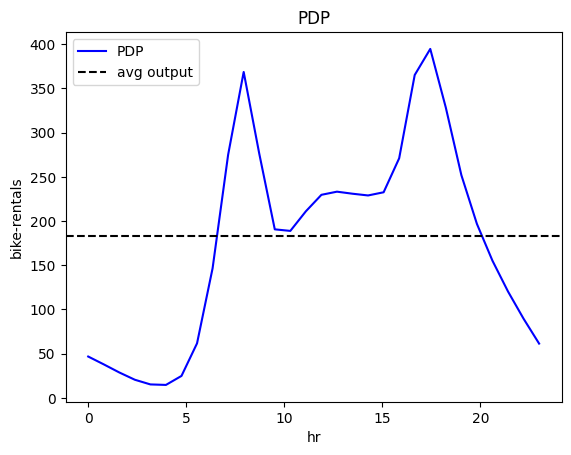

In [9]:
pdp = effector.PDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, target_name=target_name, nof_instances="all")
pdp.plot(feature=3, centering=False, scale_x=scale_x, scale_y=scale_y, show_avg_output=True)

2024-01-08 12:32:40.871922: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5694668800 exceeds 10% of free system memory.
2024-01-08 12:32:41.764261: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5694668800 exceeds 10% of free system memory.


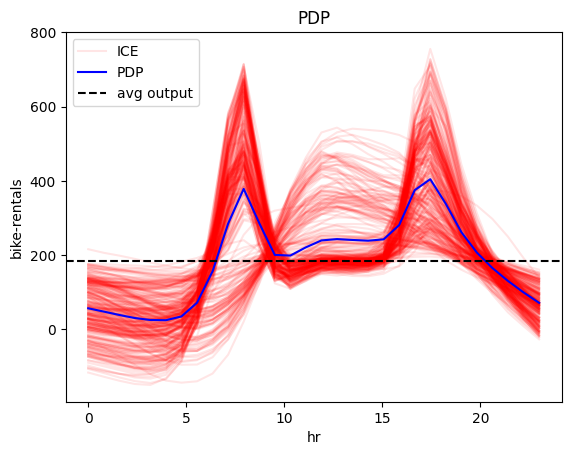

In [10]:
pdp.plot(feature=3, heterogeneity="ice", centering=True, scale_x=scale_x, scale_y=scale_y, nof_ice=300, show_avg_output=True)

### RHALE

Degrees of freedom <= 0 for slice
invalid value encountered in divide
invalid value encountered in divide


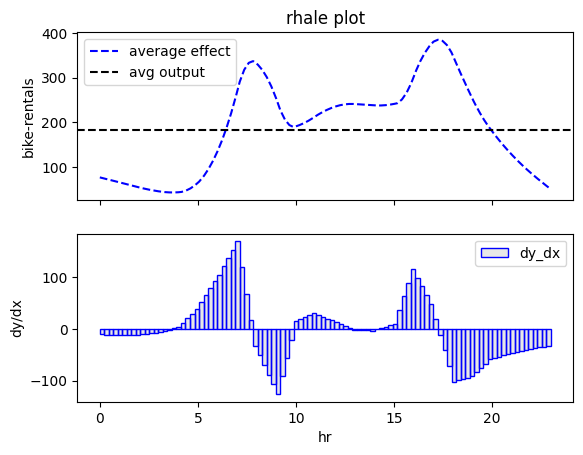

In [11]:
rhale = effector.RHALE(data=X_train.to_numpy(), model=model_forward, model_jac=model_jac, feature_names=feature_names, target_name=target_name)
rhale.fit(features=3, binning_method=effector.binning_methods.Greedy(init_nof_bins=100, min_points_per_bin=100, discount=1., cat_limit=10))
rhale.plot(feature=3, centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True)

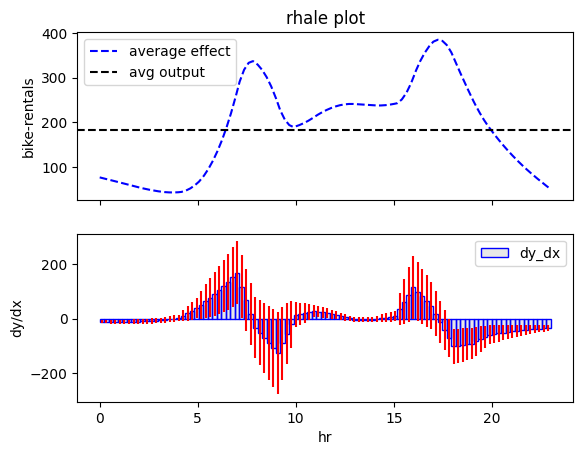

In [12]:
rhale.plot(feature=3, heterogeneity="std", centering=True, scale_x=scale_x, scale_y=scale_y, show_avg_output=True)

### Conclusion

The global effect of feature `hour` on the target variable `bike-rentals` shows two high peaks, one at around 8:00 and another at around 17:00, which probably corresponds to the morning and evening commute hours of the working days. However, the effect is quite heterogeneous. For this reason, we will analyze the regional effects which may explain the underlying heterogeneity.

## Regional Effect

### RegionalRHALE

In [13]:
# Regional RHALE
regional_rhale = effector.RegionalRHALE(
    data=X_train.to_numpy(),
    model=model_forward,
    model_jac=model_jac,
    cat_limit=10,
    feature_names=feature_names,
    nof_instances="all"
)

regional_rhale.fit(
    features=3,
    heter_small_enough=0.1,
    heter_pcg_drop_thres=0.2,
    binning_method=effector.binning_methods.Greedy(init_nof_bins=100, min_points_per_bin=100, discount=1., cat_limit=10),
    max_depth=2,
    nof_candidate_splits_for_numerical=10,
    min_points_per_subregion=10,
    candidate_conditioning_features="all",
    split_categorical_features=True,
)

100%|██████████| 1/1 [00:16<00:00, 16.42s/it]


In [14]:
regional_rhale.show_partitioning(features=3, only_important=True, scale_x_list=scale_x_list)

Feature 3 - Full partition tree:
Node id: 0, name: hr, heter: 5.92 || nof_instances: 13903 || weight: 1.00
        Node id: 1, name: hr | workingday == 0.0, heter: 2.28 || nof_instances:  4385 || weight: 0.32
        Node id: 2, name: hr | workingday != 0.0, heter: 4.58 || nof_instances:  9518 || weight: 0.68
--------------------------------------------------
Feature 3 - Statistics per tree level:
Level 0, heter: 5.92
        Level 1, heter: 3.86 || heter drop: 2.07 (34.88%)


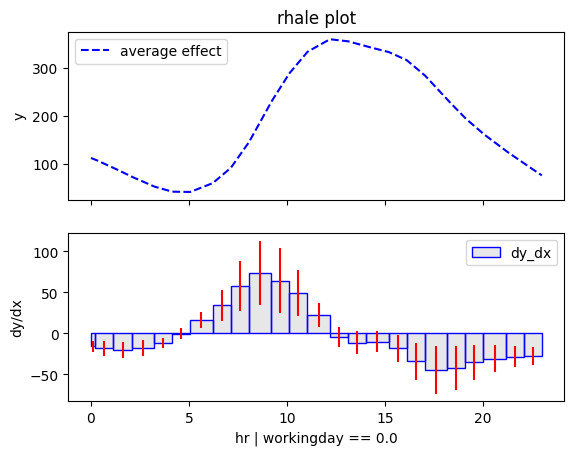

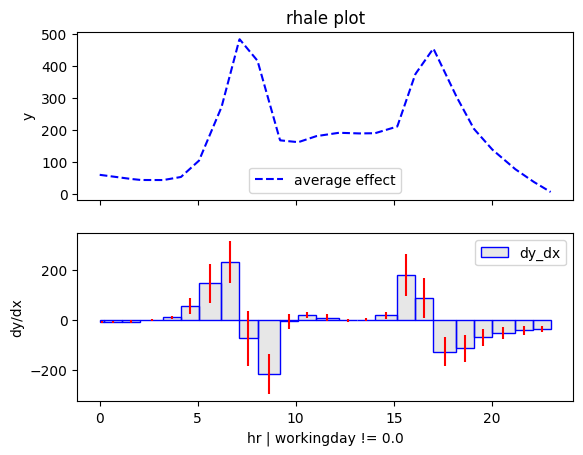

In [15]:
regional_rhale.plot(feature=3, node_idx=1, heterogeneity=True, centering=True, scale_x_list=scale_x_list, scale_y=scale_y)
regional_rhale.plot(feature=3, node_idx=2, heterogeneity=True, centering=True, scale_x_list=scale_x_list, scale_y=scale_y)

### RegionalPDP

In [16]:
regional_pdp = effector.RegionalPDP(
    data=X_train.to_numpy(),
    model=model_forward,
    cat_limit=10,
    feature_names=feature_names,
    nof_instances="all"
)

regional_pdp.fit(
    features=3,
    heter_small_enough=0.1,
    heter_pcg_drop_thres=0.1,
    max_depth=2,
    nof_candidate_splits_for_numerical=5,
    min_points_per_subregion=10,
    candidate_conditioning_features="all",
    split_categorical_features=True,
    nof_instances=1000
)

100%|██████████| 1/1 [00:15<00:00, 15.38s/it]


In [17]:
regional_pdp.show_partitioning(features=3, only_important=True, scale_x_list=scale_x_list)

Feature 3 - Full partition tree:
Node id: 0, name: hr, heter: 0.55 || nof_instances: 13903 || weight: 1.00
        Node id: 1, name: hr | workingday == 1.0, heter: 0.43 || nof_instances:  9518 || weight: 0.68
                Node id: 3, name: hr | workingday == 1.0 and season == 1.0, heter: 0.29 || nof_instances:  2245 || weight: 0.16
                Node id: 4, name: hr | workingday == 1.0 and season != 1.0, heter: 0.38 || nof_instances:  7273 || weight: 0.52
        Node id: 2, name: hr | workingday != 1.0, heter: 0.44 || nof_instances:  4385 || weight: 0.32
                Node id: 5, name: hr | workingday != 1.0 and season == 1.0, heter: 0.28 || nof_instances:  1140 || weight: 0.08
                Node id: 6, name: hr | workingday != 1.0 and season != 1.0, heter: 0.38 || nof_instances:  3245 || weight: 0.23
--------------------------------------------------
Feature 3 - Statistics per tree level:
Level 0, heter: 0.55
        Level 1, heter: 0.43 || heter drop: 0.12 (22.43%)
        

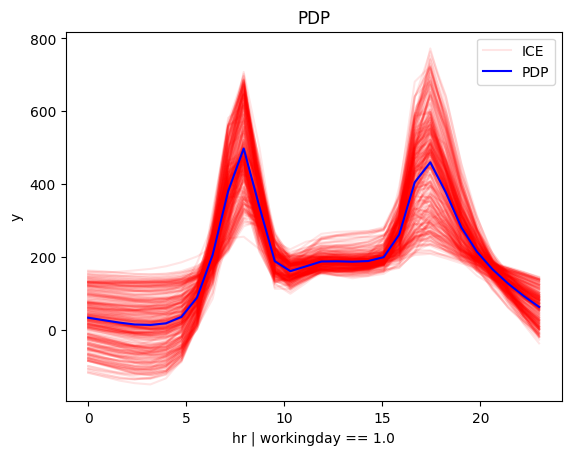

In [18]:
regional_pdp.plot(feature=3, node_idx=1, heterogeneity="ice", centering=True, scale_x_list=scale_x_list, scale_y=scale_y)

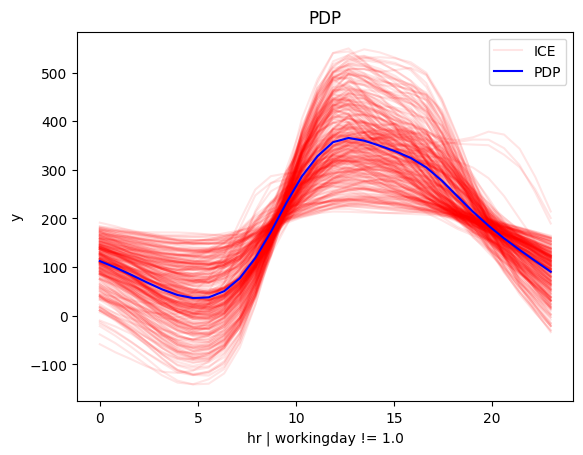

In [19]:
regional_pdp.plot(feature=3, node_idx=2, heterogeneity="ice", centering=True, scale_x_list=scale_x_list, scale_y=scale_y)

### Conclusion

The both PDP and RHALE regional effect reveal two distinct explanations; one for the working days and another for the non-working days. For the working days, the effect is quite similar to the global effect (unfortunately, working ways dominate our life), with two high peaks at around 8:00 and 17:00. However, for the non-working days, the effect is quite different, with a single high peak at around 13:00 which probably corresponds to sightseeing and leisure activities.